In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as ks
import torch
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from torch.utils.data import TensorDataset, RandomSampler, DataLoader
from pytorch_pretrained_bert import BertForSequenceClassification, BertAdam
from tqdm import tqdm, trange


In [56]:
df = pd.read_csv(r"C:\Users\Mustafa Minhas\PycharmProjects\Helloworld\BERT Performance analysis\cola_public\raw\in_domain_train.tsv", delimiter = '\t', header =None, names =['sentence_source', 'label', 'label_notes', 'sentence'])
df=df[0:1000]
df.shape

(1000, 4)

In [57]:
#adding tokens at the start and end of the sentences

sentences = df.sentence.values
sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df.label.values

In [58]:
#1- initiaize Bert tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
tokenized_tests = [tokenizer.tokenize(sent) for sent in sentences]
print('Tokenize the first sentense: ')
print(tokenized_tests[0])

Tokenize the first sentense: 
['[', 'cl', '##s', ']', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[', 'sep', ']']


In [59]:
#2- BERT requires specific input sentense having input id, segment mask, attention mask, labels

#input id : to donate each token
#segment mask: to identify if input is one or more then one sentense
#attention mask: padding or truncating the sentense if it is short or long with the respect to the maximum length
#labels: 1 or 0 showing the sentense is grammatical or ungrammatical

max_len = 128 #setting max length of the sentense as 128 characters

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_tests]


#padding our input ids 
input_ids = pad_sequences(
                input_ids,
                maxlen =max_len,
                dtype = 'long',
                truncating = 'post',
                padding = 'post'
)


In [60]:
#Attention masks

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq] ## Create a mask of 1s for each token followed by 0s for padding
    attention_masks.append(seq_mask)
    

In [61]:
#Model Selection

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size= 0.1, random_state = 2018)
train_masks, validation_masks, _,_ =train_test_split(attention_masks, input_ids, test_size=0.1, random_state =2018)



In [62]:
#Convert our traininig and test sets into torch tensors 

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


In [63]:
#selecting the batch_size, which should b 16 or 32 for better performance

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler ,batch_size = batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size= batch_size)

#Here, Now , this is our data properly formatted ready fro BERT


In [65]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels =2)

In [66]:
#authors recommend the following hyper parameter taken inside the loaded model

param_optimizer  = list(model.named_parameters())
no_decay  = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
        {'params' : [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}]
    
    

In [67]:
optimizer = BertAdam(optimizer_grouped_parameters, lr = 2e-5, warmup = .1)

t_total value of -1 results in schedule not being applied


In [68]:
#Fucntion to calculate accuracy of our predictions and labels

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [69]:
t = [] 
train_loss_set = [] # Store our loss and accuracy for plotting
epochs = 2 # Number of training epochs 

for _ in trange(epochs, desc="Epoch"): # trange is a tqdm wrapper around the normal python range
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    b_input_ids, b_input_mask, b_labels = batch  
    optimizer.zero_grad()
    # Forward pass
    b_input_ids = torch.tensor(b_input_ids).long()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      b_input_ids = torch.tensor(b_input_ids).long()
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    

Epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Train loss: 0.6742940195675554


Epoch:  50%|█████████████████████████████████████▌                                     | 1/2 [23:47<23:47, 1427.59s/it]

Validation Accuracy: 0.5546875
Train loss: 0.6526525596092487


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [47:23<00:00, 1421.54s/it]

Validation Accuracy: 0.6640625


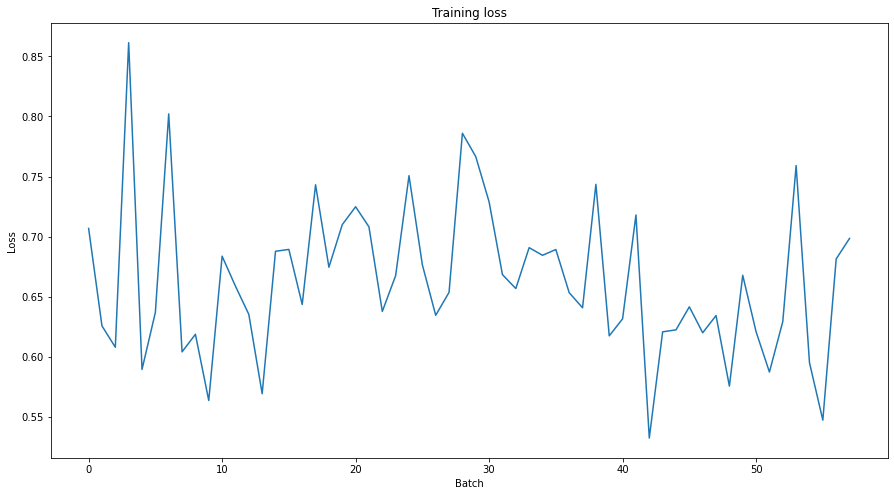

In [71]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()